In [1]:
import torchvision
import numpy as np
from Torch_Pruning.examples.cifar_minimal.cifar_resnet import ResNet18
import Torch_Pruning.examples.cifar_minimal.cifar_resnet as resnet

import Torch_Pruning.torch_pruning as tp
import argparse
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn 
import numpy as np 
import os

In [2]:
def get_dataloader():
    train_loader = torch.utils.data.DataLoader(
        CIFAR10('./data', train=True, transform=transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]), download=True),batch_size=256, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        CIFAR10('./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
        ]),download=True),batch_size=256, num_workers=2)
    return train_loader, test_loader

def eval(model, test_loader):
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (img, target) in enumerate(test_loader):
            img = img.to(device)
            out = model(img)
            pred = out.max(1)[1].detach().cpu().numpy()
            target = target.cpu().numpy()
            correct += (pred==target).sum()
            total += len(target)
    return correct / total

def train_model(model, train_loader, test_loader, epochs, round_num, j):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 70, 0.1)
    model.to(device)

    acc_s = []
    best_acc = -1
    for epoch in range(epochs):
        model.train()
        for i, (img, target) in enumerate(train_loader):
            img, target = img.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = F.cross_entropy(out, target)
            loss.backward()
            optimizer.step()
#             if i%10==0 and args.verbose:
#                 print("Epoch %d/%d, iter %d/%d, loss=%.4f"%(epoch, args.total_epochs, i, len(train_loader), \
# loss.item()))
        model.eval()
        acc = eval(model, test_loader)
#         print("Epoch %d/%d, Acc=%.4f"%(epoch, epochs, acc))
        acc_s.append(acc)
        if best_acc<acc:
            torch.save( model, f'resnet18-round{round_num}_{j}.pth' )
            best_acc=acc
        scheduler.step()
#     print("Best Acc=%.4f"%(best_acc))
    return best_acc, np.mean(acc_s)

def prune_model(model, block_prune_probs, strategy_name='l1'):
    model.cpu()
    DG = tp.DependencyGraph().build_dependency( model, torch.randn(1, 3, 32, 32) )
    def prune_conv(conv, amount=0.2, strategy_name='l1'):
        strategy = tp.strategy.L1Strategy() if strategy_name == 'l1' else tp.strategy.RandomStrategy()
        pruning_index = strategy(conv.weight, amount=amount)
        plan = DG.get_pruning_plan(conv, tp.prune_conv_out_channel, pruning_index)
        plan.exec()
    
    blk_id = 0
    for m in model.modules():
        if isinstance(m, resnet.BasicBlock):
            prune_conv(m.conv1, block_prune_probs[blk_id], strategy_name)
            prune_conv(m.conv2, block_prune_probs[blk_id], strategy_name)
            blk_id+=1
#     print(model)
    return model 

In [3]:
def count_params(model):
    params = sum([np.prod(p.size()) for p in model.parameters()])
    print("Number of Parameters: %.1fM"%(params/1e6))
    return params

In [4]:
train_loader, test_loader = get_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
dicts = []

In [6]:
block_probs = [
    [0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3],
    [0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1],
    [0.3, 0.3, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6],
    [0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.3, 0.3],
]

In [7]:
for j, probs in enumerate(block_probs):
    print(f'Probs: {probs}')
    print('--------------------------')
    model = ResNet18(num_classes=10)
    model_dict = {
        'best': [],
        'mean': [],
        'params': [],
        'size': [],
        'out_ch': [],
        'macs_params': []
    }
    for i in range(6):
        print(f'------ Round {i} ------')
        if i > 0:
            prune_model(model, probs, 'l1')
        param = count_params(model)
        best, mean = train_model(model, train_loader, test_loader, 100 if i == 0 else 30, i, j)
        model_dict['best'].append(best)
        model_dict['mean'].append(mean)
        model_dict['params'].append(param)
        model_dict['size'].append(os.path.getsize(f'resnet18-round{i}_{j}.pth') / 1024 / 1024)
        model_dict['macs_params'].append(tp.utils.count_macs_and_params(model.cpu(), (1,3,32,32)))
        print(f"Model Size: {model_dict['size'][-1]:.3f} MB")
        print(f"MACs: {model_dict['macs_params'][-1][0] / 1e6:.3f} M")

        ch = []
        for a in model.modules():
            if isinstance(a, torch.nn.modules.conv.Conv2d):
                ch.append(a.weight.shape[0])
        model_dict['out_ch'].append(ch)
    dicts.append(model_dict)
    print('--------------------------')

Probs: [0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3]
--------------------------
------ Round 0 ------
Number of Parameters: 11.2M
Model Size: 42.707 MB
MACs: 442.324 M
------ Round 1 ------
Number of Parameters: 4.5M
Model Size: 17.213 MB
MACs: 219.555 M
------ Round 2 ------
Number of Parameters: 1.9M
Model Size: 7.307 MB
MACs: 115.663 M
------ Round 3 ------
Number of Parameters: 0.8M
Model Size: 3.288 MB
MACs: 64.215 M
------ Round 4 ------
Number of Parameters: 0.4M
Model Size: 1.600 MB
MACs: 37.784 M
------ Round 5 ------
Number of Parameters: 0.2M
Model Size: 0.846 MB
MACs: 23.314 M
--------------------------
Probs: [0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1]
--------------------------
------ Round 0 ------
Number of Parameters: 11.2M
Model Size: 42.707 MB
MACs: 442.324 M
------ Round 1 ------
Number of Parameters: 7.3M
Model Size: 27.984 MB
MACs: 245.278 M
------ Round 2 ------
Number of Parameters: 4.9M
Model Size: 18.864 MB
MACs: 143.167 M
------ Round 3 ------
Number of Parameters: 3

In [8]:
dicts

[{'best': [0.9262, 0.8892, 0.8836, 0.8863, 0.87, 0.8673],
  'mean': [0.8489420000000001,
   0.8671399999999998,
   0.8644500000000002,
   0.8607699999999999,
   0.8542733333333334,
   0.8375066666666665],
  'params': [11173962, 4493525, 1898868, 846389, 405164, 207707],
  'size': [42.70704364776611,
   17.212563514709473,
   7.306679725646973,
   3.2883081436157227,
   1.5998926162719727,
   0.8461084365844727],
  'out_ch': [[64,
    64,
    64,
    64,
    64,
    128,
    128,
    128,
    128,
    128,
    256,
    256,
    256,
    256,
    256,
    512,
    512,
    512,
    512,
    512],
   [53,
    58,
    53,
    58,
    53,
    103,
    83,
    83,
    103,
    83,
    205,
    164,
    164,
    205,
    164,
    359,
    252,
    252,
    359,
    252],
   [44,
    53,
    44,
    53,
    44,
    83,
    54,
    54,
    83,
    54,
    164,
    106,
    106,
    164,
    106,
    252,
    124,
    124,
    252,
    124],
   [36,
    48,
    36,
    48,
    36,
    67,
    36

In [9]:
import matplotlib.pyplot as plt

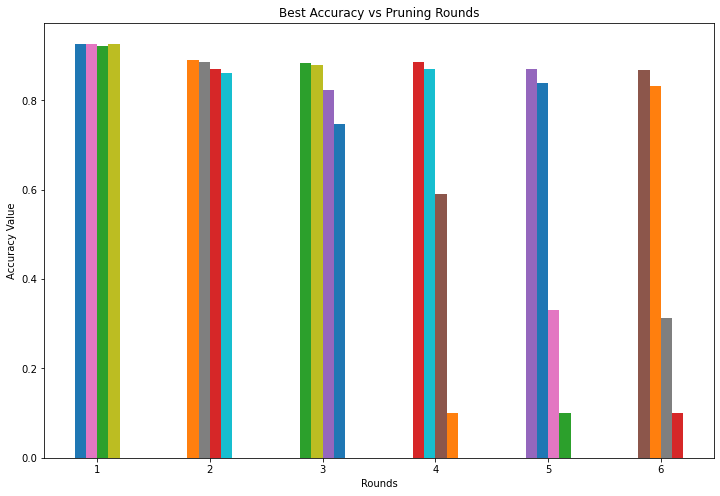

In [14]:
plt.figure(figsize=(12, 8))
deltas = [-0.15, -0.05, 0.05, 0.15]
X = np.arange(1, 7)
for i in range(4):
    p = dicts[i]['best']
    for j in range(6):
        plt.bar(X[j] + deltas[i], p[j], 0.1)
plt.xlabel('Rounds')
plt.ylabel('Accuracy Value')
plt.title('Best Accuracy vs Pruning Rounds')
plt.show()


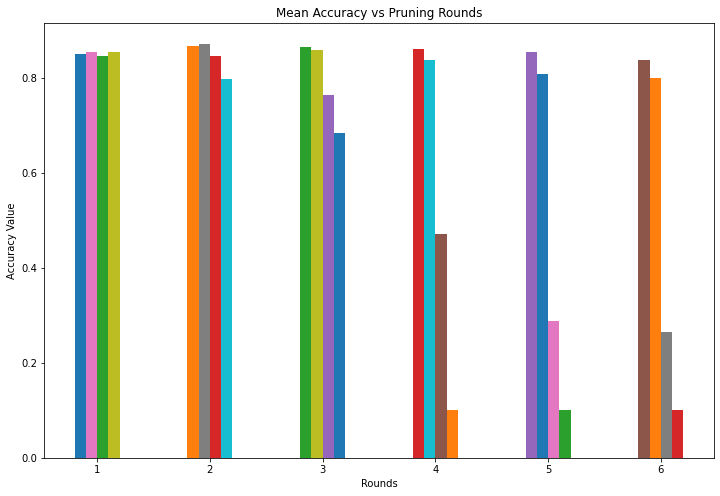

In [17]:
plt.figure(figsize=(12, 8))
deltas = [-0.15, -0.05, 0.05, 0.15]
X = np.arange(1, 7)
for i in range(4):
    p = dicts[i]['mean']
    for j in range(6):
        plt.bar(X[j] + deltas[i], p[j], 0.1)
plt.xlabel('Rounds')
plt.ylabel('Accuracy Value')
plt.title('Mean Accuracy vs Pruning Rounds')
plt.show()


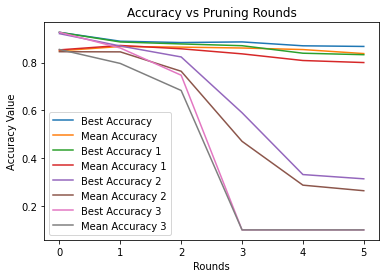

In [18]:
plt.plot(dicts[0]['best'], label='Best Accuracy')
plt.plot(dicts[0]['mean'], label='Mean Accuracy')
plt.plot(dicts[1]['best'], label='Best Accuracy 1')
plt.plot(dicts[1]['mean'], label='Mean Accuracy 1')
plt.plot(dicts[2]['best'], label='Best Accuracy 2')
plt.plot(dicts[2]['mean'], label='Mean Accuracy 2')
plt.plot(dicts[3]['best'], label='Best Accuracy 3')
plt.plot(dicts[3]['mean'], label='Mean Accuracy 3')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Accuracy Value')
plt.title('Accuracy vs Pruning Rounds')
plt.show()

In [19]:
dicts[0]['params'], dicts[1]['params'], dicts[2]['params'], dicts[3]['params']

([11173962, 4493525, 1898868, 846389, 405164, 207707],
 [11173962, 7315915, 4926427, 3387966, 2369030, 1676095],
 [11173962, 968608, 108719, 18350, 5146, 2278],
 [11173962, 3005213, 926288, 305340, 107024, 39564])

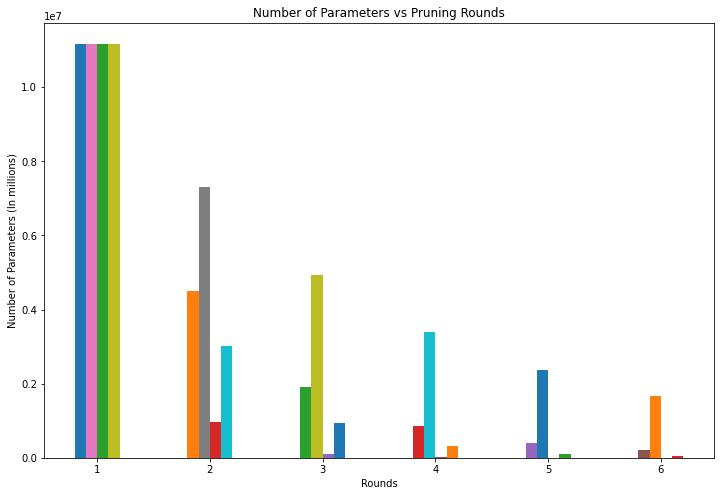

In [20]:
plt.figure(figsize=(12, 8))
deltas = [-0.15, -0.05, 0.05, 0.15]
X = np.arange(1, 7)
for i in range(4):
    p = dicts[i]['params']
    for j in range(6):
        plt.bar(X[j] + deltas[i], p[j], 0.1)
plt.xlabel('Rounds')
plt.ylabel('Number of Parameters (In millions)')
plt.title('Number of Parameters vs Pruning Rounds')
plt.show()


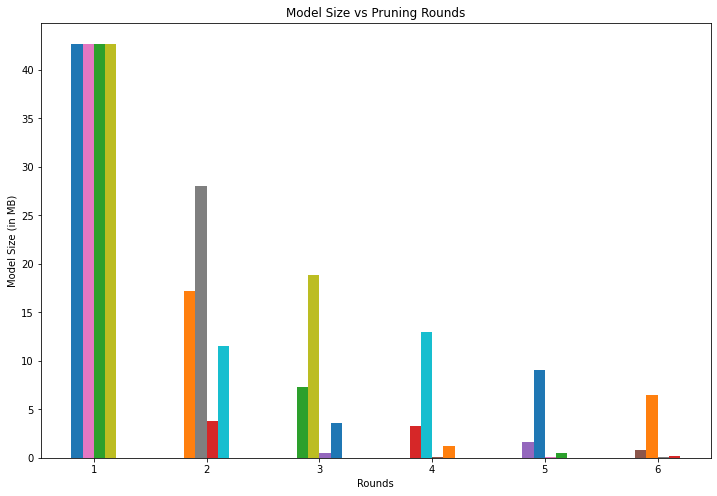

In [21]:
plt.figure(figsize=(12, 8))
deltas = [-0.15, -0.05, 0.05, 0.15]
X = np.arange(1, 7)
for i in range(4):
    p = dicts[i]['size']
    for j in range(6):
        plt.bar(X[j] + deltas[i], p[j], 0.1)
plt.xlabel('Rounds')
plt.ylabel('Model Size (in MB)')
plt.title('Model Size vs Pruning Rounds')
plt.show()


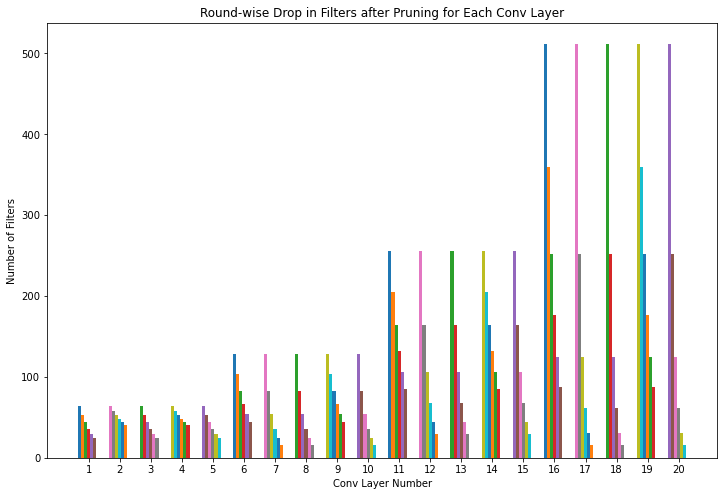

In [22]:
X = np.arange(1, 21)
plt.figure(figsize=(12, 8))
# colors = ['g', 'b', 'y', 'm', 'c', 'r']
# colors = ['lightcoral', 'teal', 'yellowgreen', 'darkturquoise', 'pink', 'orange']

deltas = [-0.3, -0.2, -0.1, 0, 0.1, 0.2]
for i in range(len(dicts[0]['out_ch'][0])):
    x = [a[i] for a in dicts[0]['out_ch']]
    for j in range(len(deltas)):
        plt.bar(X[i] + deltas[j], x[j], 0.1)#, color=colors[j])
plt.xticks(X)
plt.xlabel('Conv Layer Number')
plt.ylabel('Number of Filters')
plt.title('Round-wise Drop in Filters after Pruning for Each Conv Layer')
plt.show()

In [25]:
import pandas as pd

In [26]:
cols = [f'Conv Layer {i+1}' for i in range(len(dicts[0]['out_ch'][0]))]
idxs = [f'Round {i+1}' for i in range(len(dicts[0]['out_ch']))]
pd.DataFrame(dicts[0]['out_ch'], columns = cols, index=idxs).transpose().head(20)

,Round 1,Round 2,Round 3,Round 4,Round 5,Round 6
Conv Layer 1,64,53,44,36,30,25
Conv Layer 2,64,58,53,48,44,40
Conv Layer 3,64,53,44,36,30,25
Conv Layer 4,64,58,53,48,44,40
Conv Layer 5,64,53,44,36,30,25
Conv Layer 6,128,103,83,67,54,44
Conv Layer 7,128,83,54,36,24,16
Conv Layer 8,128,83,54,36,24,16
Conv Layer 9,128,103,83,67,54,44
Conv Layer 10,128,83,54,36,24,16


In [27]:
for i in range(len(dicts[0]['out_ch'][0])):
    filters = [a[i] for a in dicts[0]['out_ch']]
    print(f'Number of Filters in Layer {i+1} in each round: ', end='')
    for x, j in enumerate(filters):
        print(str(j), end='')
        if x != len(dicts[0]['out_ch']) - 1:
            print(" => ", end='')
    print()

Number of Filters in Layer 1 in each round: 64 => 53 => 44 => 36 => 30 => 25
Number of Filters in Layer 2 in each round: 64 => 58 => 53 => 48 => 44 => 40
Number of Filters in Layer 3 in each round: 64 => 53 => 44 => 36 => 30 => 25
Number of Filters in Layer 4 in each round: 64 => 58 => 53 => 48 => 44 => 40
Number of Filters in Layer 5 in each round: 64 => 53 => 44 => 36 => 30 => 25
Number of Filters in Layer 6 in each round: 128 => 103 => 83 => 67 => 54 => 44
Number of Filters in Layer 7 in each round: 128 => 83 => 54 => 36 => 24 => 16
Number of Filters in Layer 8 in each round: 128 => 83 => 54 => 36 => 24 => 16
Number of Filters in Layer 9 in each round: 128 => 103 => 83 => 67 => 54 => 44
Number of Filters in Layer 10 in each round: 128 => 83 => 54 => 36 => 24 => 16
Number of Filters in Layer 11 in each round: 256 => 205 => 164 => 132 => 106 => 85
Number of Filters in Layer 12 in each round: 256 => 164 => 106 => 68 => 44 => 29
Number of Filters in Layer 13 in each round: 256 => 164 =>

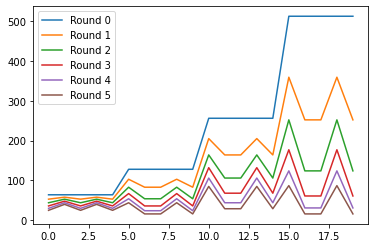

In [28]:
for i in range(len(dicts[0]['out_ch'])):
    plt.plot(dicts[0]['out_ch'][i], label=f'Round {i}')
plt.legend()
plt.show()

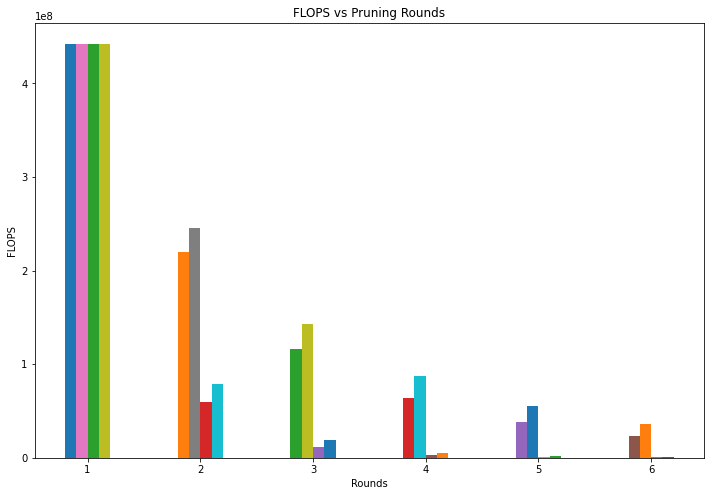

In [29]:
plt.figure(figsize=(12, 8))
deltas = [-0.15, -0.05, 0.05, 0.15]
X = np.arange(1, 7)
for i in range(4):
    p = dicts[i]['macs_params']
    for j in range(6):
        plt.bar(X[j] + deltas[i], p[j], 0.1)
plt.xlabel('Rounds')
plt.ylabel('FLOPS')
plt.title('FLOPS vs Pruning Rounds')
plt.show()


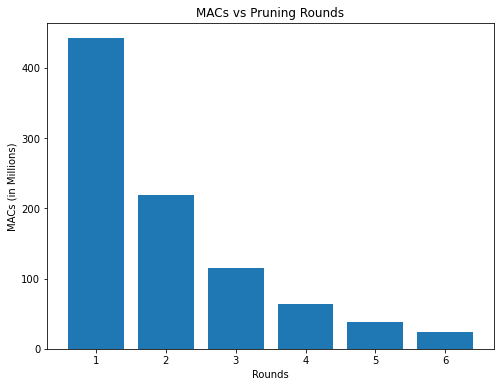

In [33]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1, 7), [a[0]/1e6 for a in dicts[0]['macs_params']])
plt.xlabel('Rounds')
plt.ylabel('MACs (in Millions)')
plt.title('MACs vs Pruning Rounds')
plt.show()